### Similarity Calculation

In [1]:
import os 
import pandas as pd
import nltk
import matplotlib.pyplot as plt
import datetime
import statsmodels.api as sm
import statsmodels.formula.api as smf
import numpy as np
os.chdir('E:\\RSM\\Thesis result')

In [2]:
input_accounts = pd.read_csv("input_accounts_21_10_2022.csv")
tweets = pd.read_csv("tweets-2022-10-21.csv")## import the data

In [3]:
#select English tweets
df_posts = tweets.loc[tweets['lang']=='en']

#import the module and create a list of stopwords
from nltk.corpus import stopwords

additional  = ['rt','rts','retweet','number','look','read','food','eat','amp','us','email','dm','pls','pleas',
              'hi','hey','team','thank','dmu','reach','take','drop','send','uk'] 
swords = set().union(stopwords.words('english'),additional)
#replace all signs and stopwords in tweets and tokenize tweets (tokenization means splitting up a larger body of text into pieces such as words, keywords, phrases, symbols and other elements called tokens; in our case we can split the tweets into words)
df_posts.drop_duplicates(subset='text',inplace=True)
df_posts.shape
df_posts['processed_text'] = df_posts['text'].str.lower()\
          .str.replace('(@[a-z0-9]+)\w+',' ')\
          .str.replace('(http\S+)', ' ')\
          .str.replace('([^0-9a-z \t])',' ')\
          .str.replace(' +',' ')\
          .apply(lambda x: [i for i in x.split() if not i in swords])

#stem tweets to combine similar texts
from nltk.stem import PorterStemmer
ps = PorterStemmer()
df_posts['stemmed'] = df_posts['processed_text'].apply(lambda x: [ps.stem(i) for i in x if i != ''])



C:\Users\Jiang Bowen\AppData\Local\Temp\ipykernel_86012\3516227849.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_posts.drop_duplicates(subset='text',inplace=True)
C:\Users\Jiang Bowen\AppData\Local\Temp\ipykernel_86012\3516227849.py:13: FutureWarning: The default value of regex will change from True to False in a future version.
  df_posts['processed_text'] = df_posts['text'].str.lower()\
C:\Users\Jiang Bowen\AppData\Local\Temp\ipykernel_86012\3516227849.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_posts['processed_text'] = df_posts['text'].s

In [4]:
# Convert variables to strings
for index, row in df_posts.iterrows():
    df_posts.at[index, 'processed_text'] = str(row['processed_text'])


In [5]:
from sklearn.feature_extraction.text import CountVectorizer

countvec = CountVectorizer(min_df=10, max_df=100)  # Keep words that appear in more than 50 reports, exclude words that appear in more than 1000 reports

res = countvec.fit_transform(df_posts.processed_text)  # Sparse bag-of-words matrix
doc_term_matrix = res.toarray()


In [7]:
# Normalize using the total word count of the company
import numpy as np

def normalizer(vec):
    denom = np.sum(vec)
    return vec / denom

doc_term_matrix_normalizer = []
for vec in doc_term_matrix:
    doc_term_matrix_normalizer.append(normalizer(vec))

print(doc_term_matrix_normalizer)


C:\Users\Jiang Bowen\AppData\Local\Temp\ipykernel_86012\683246163.py:5: RuntimeWarning: invalid value encountered in divide
  return (vec/ denom)


[array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([nan, nan, nan, ..., nan, nan, nan]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([nan, nan, nan, ..., nan, nan, nan]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0. , 0. , 0.2, ..., 0. , 0. , 0. ]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0.,

In [11]:
#similarity calculation 
data_processed=pd.DataFrame(doc_term_matrix_normalizer)
data_processed['conversation_id'] = df_posts['conversation_id']
for i in range(0,14756):
    df_firm = data_processed.iloc[i:i+1]
    df_firm = df_firm.melt(id_vars=['conversation_id'],    
                            var_name="wordid",  
                            value_name="freq")   


    market_matrix = data_processed[data_processed["conversation_id"] != data_processed.iloc[i]["conversation_id"]]
    market_matrix = market_matrix.drop(["conversation_id"],axis=1)
    normmarket = market_matrix.mean(axis = 0)
    

    df_firm["freq_market_ind"] = normmarket.tolist()
    
    
    x = df_firm.loc[:,('freq_market_ind')]
    y = df_firm['freq']
    x = sm.add_constant(x)

    from sklearn.model_selection import train_test_split
    x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=0)
    ols = sm.OLS(y_train, x_train)
    models = ols.fit()
    y_predict = models.predict(x_train)
    df_firm['e']=abs(y_train - y_predict) # (n_samples,)
    data_processed.loc[i,1228]=df_firm['e'].sum()


In [12]:
df_posts["similarity"]=data_processed[1228]

C:\Users\Jiang Bowen\AppData\Local\Temp\ipykernel_86012\662146424.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_posts["similarity"]=data_processed[1228]


### Data Description 

In [13]:
#select  tweets published by JustEatTakeaway(JET)， Uber and Deliveroo 
JET = df_posts.loc[df_posts['user_id'].isin([272030125,21427907,25320756])]
Deliveroo = df_posts.loc[df_posts['user_id'].isin([884794020])]
Uber = df_posts.loc[df_posts['user_id'].isin([3100005042,1123948811691470849])]

#create dataframe only containts retweets 
JET_re = JET.loc[JET["replied_to_id"] != -1]
Deliveroo_re = Deliveroo.loc[Deliveroo["replied_to_id"] != -1]
Uber_re = Uber.loc[Uber["replied_to_id"] != -1]

#create dataframe only containts original posts
JET_or = JET.loc[JET["replied_to_id"] == -1]
Deliveroo_or = Deliveroo.loc[Deliveroo["replied_to_id"] == -1]
Uber_or = Uber.loc[Uber["replied_to_id"] == -1]

In [14]:
#stem tweets to combine similar texts
from nltk.stem import PorterStemmer
ps = PorterStemmer()
df_posts['stemmed'] = df_posts['processed_text'].apply(lambda x: [ps.stem(i) for i in x if i != ''])
df_posts['stemmed'].head(10)

C:\Users\Jiang Bowen\AppData\Local\Temp\ipykernel_86012\880537776.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_posts['stemmed'] = df_posts['processed_text'].apply(lambda x: [ps.stem(i) for i in x if i != ''])


0     [[, ', f, l, a, t, s, ', ,,  , ', w, i, n, ', ]]
1    [[, ', m, a, n, y, ', ,,  , ', f, l, a, v, o, ...
2                                               [[, ]]
3    [[, ', m, a, r, i, e, g, r, e, y, ', ,,  , ', ...
4    [[, ', e, x, t, r, a, ', ,,  , ', p, o, i, n, ...
5    [[, ', g, o, n, n, a, ', ,,  , ', s, a, y, ', ...
6    [[, ', o, k, ', ,,  , ', g, o, t, ', ,,  , ', ...
7    [[, ', l, i, t, e, r, a, l, l, y, ', ,,  , ', ...
8    [[, ', w, a, t, c, h, ', ,,  , ', o, n, e, ', ...
9    [[, ', i, c, o, n, s, ', ,,  , ', a, r, o, u, ...
Name: stemmed, dtype: object

In [15]:
#create dataframe only containts retweets 
retweets = df_posts.loc[df_posts["replied_to_id"] != -1]
#create dataframe only containts original posts
origintweets = df_posts.loc[df_posts["replied_to_id"] == -1]
origintweets.shape
retweets.shape

(12202, 21)

In [16]:
#Main topics for retweets  
import re
words = JET_re['stemmed'].dropna()\
                            .apply(lambda y: pd.value_counts(re.findall('([\s]\w+[\s])',' '.join(y))))\
                            .sum(axis=0)\
                            .to_frame()\
                            .reset_index()\
                            .sort_values(by=0,ascending=False)
words.columns = ['word','occurences']
pd.set_option('display.max_rows', 500)
words.to_excel("JETre_wordcount.xlsx")
words.head(30)

,word,occurences
1,pleas,1266.0
19,like,869.0
18,order,817.0
2,thank,655.0
29,reach,476.0
65,could,457.0
146,hear,418.0
26,get,416.0
20,hand,413.0
12,twitter,409.0


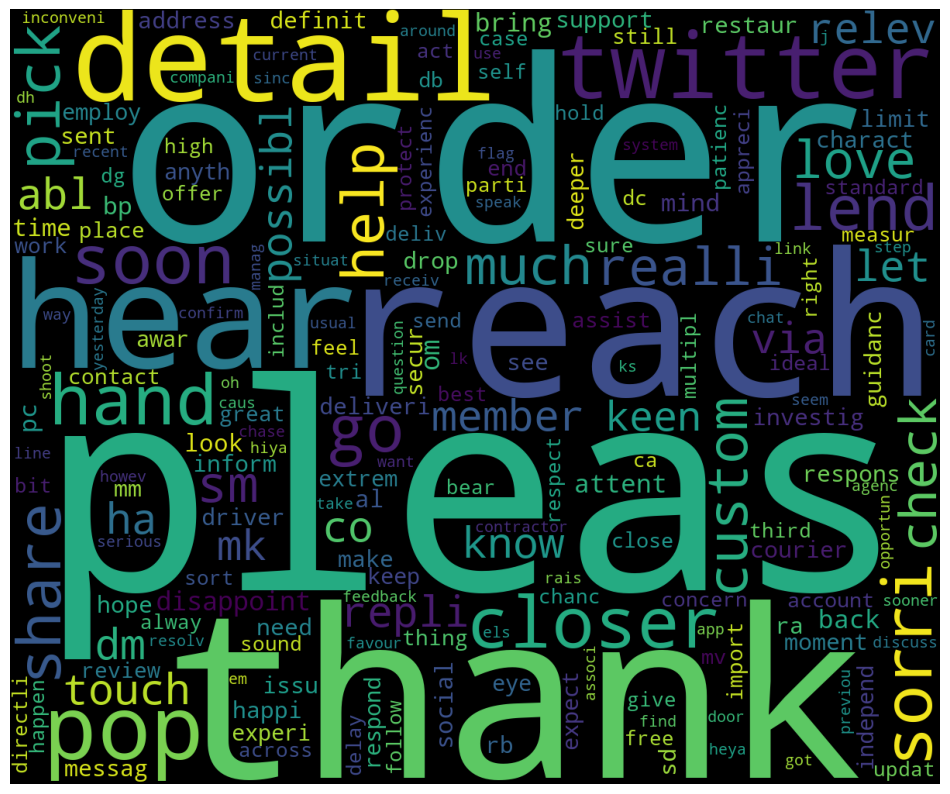

In [20]:
#wordcloud for retweet

from wordcloud import WordCloud, STOPWORDS
bigstring = JET_re['stemmed'].apply(lambda x: ' '.join(x)).str.cat(sep=' ')
plt.figure(figsize=(12,12))
wordcloud = WordCloud(stopwords=STOPWORDS,
                          background_color='black',
                          collocations=False,
                          width=1200,
                          height=1000
                         ).generate(bigstring)
plt.axis('off')
plt.imshow(wordcloud)

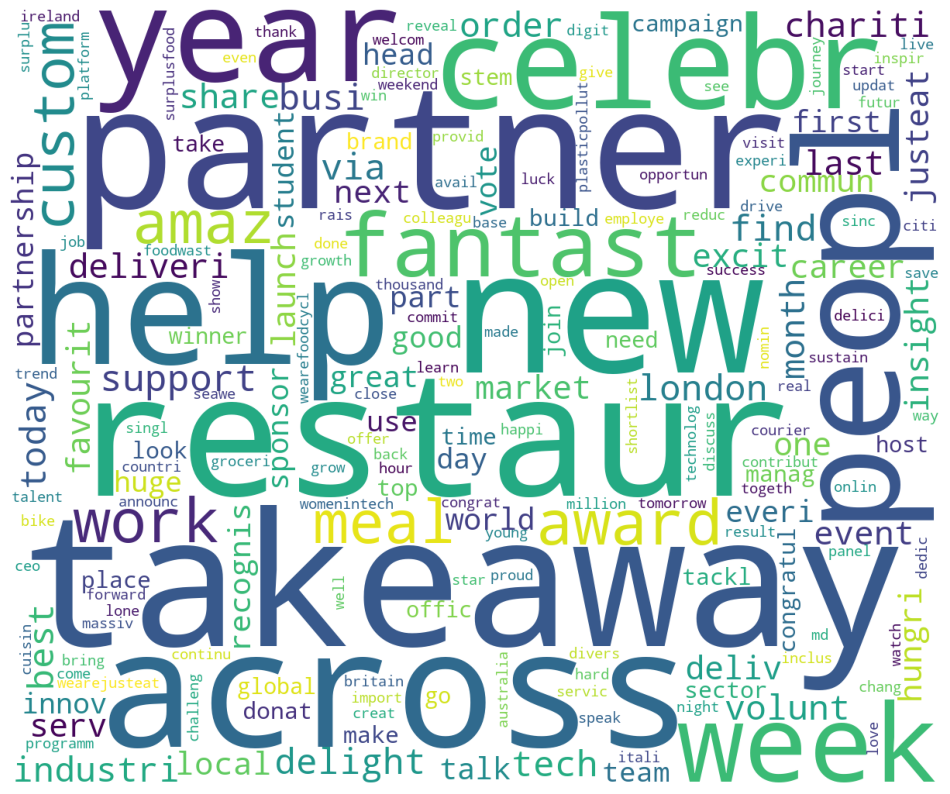

In [21]:
#wordcloud for original tweets

from wordcloud import WordCloud, STOPWORDS
bigstring = JET_or['stemmed'].apply(lambda x: ' '.join(x)).str.cat(sep=' ')
plt.figure(figsize=(12,12))
wordcloud = WordCloud(stopwords=STOPWORDS,
                          background_color='white',
                          collocations=False,
                          width=1200,
                          height=1000
                         ).generate(bigstring)
plt.axis('off')
plt.imshow(wordcloud)

In [22]:
#bigrams for retweets     
from nltk import bigrams
bigramseries = pd.Series([word for sublist in JET_re['stemmed'].dropna()\
                    .apply(lambda x: [i for i in bigrams(x)])\
                    .tolist() for word in sublist])\
                    .value_counts()
plt.suptitle('Top 10 Bigrams for keywords in retweets', fontsize=10)
bigramseries[:10]

(thank, reach)     636
(twitter, com)     608
(could, pleas)     579
(pleas, order)     461
(lend, hand)       459
(pop, order)       420
(sorri, hear)      414
(reach, like)      365
(like, closer)     328
(closer, could)    305
dtype: int64

<Figure size 640x480 with 0 Axes>

In [23]:
#bigrams for original tweets
from nltk import bigrams
bigramseries = pd.Series([word for sublist in JET_or['stemmed'].dropna()\
                    .apply(lambda x: [i for i in bigrams(x)])\
                    .tolist() for word in sublist])\
                    .value_counts()
plt.suptitle('Top 10 Bigrams for keywords in original tweets', fontsize=10)
bigramseries[:10]

(restaur, partner)      98
(chariti, partner)      83
(share, insight)        60
(amaz, volunt)          47
(takeaway, industri)    45
(fantast, chariti)      45
(peopl, across)         43
(lone, peopl)           40
(hungri, lone)          40
(young, peopl)          35
dtype: int64

<Figure size 640x480 with 0 Axes>

Text(0.5, 0.98, 'Top 10 Hashtags:JET original tweets')

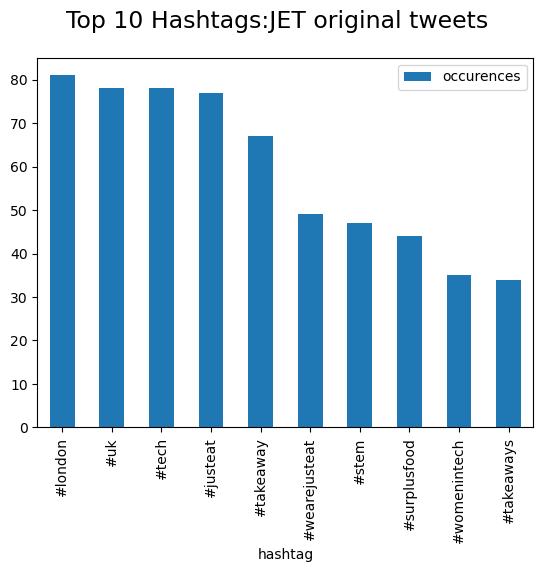

In [24]:
import re
hashtags = JET_or['text'].apply(lambda x: pd.value_counts(re.findall('(#\w+)', x.lower() )))\
                     .sum(axis=0)\
                     .to_frame()\
                     .reset_index()\
                     .sort_values(by=0,ascending=False)
hashtags.columns = ['hashtag','occurences']

hashtags[:10].plot(kind='bar',y='occurences',x='hashtag')
plt.suptitle('Top 10 Hashtags:JET original tweets', fontsize=17)

Text(0.5, 0.98, 'Top 10 Hashtags:JET retweets')

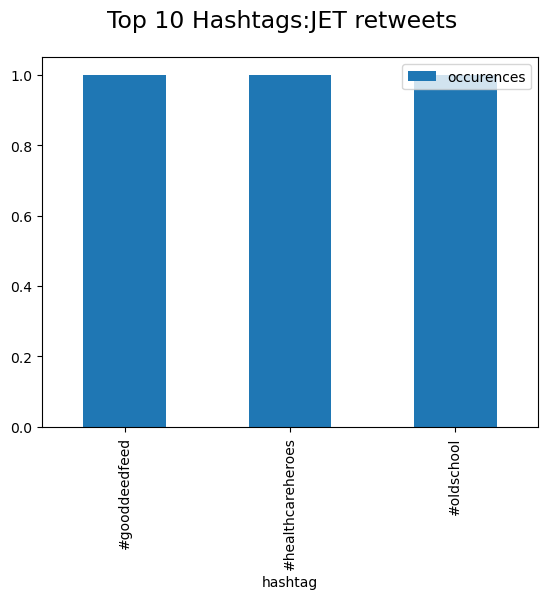

In [25]:
import re
hashtags = JET_re['text'].apply(lambda x: pd.value_counts(re.findall('(#\w+)', x.lower() )))\
                     .sum(axis=0)\
                     .to_frame()\
                     .reset_index()\
                     .sort_values(by=0,ascending=False)
hashtags.columns = ['hashtag','occurences']
hashtags.head(10)
hashtags[:10].plot(kind='bar',y='occurences',x='hashtag')
plt.suptitle('Top 10 Hashtags:JET retweets', fontsize=17)

In [26]:
#create year,month,hour for charts  
JET['year'] = pd.to_datetime(JET['created_at']).dt.year
JET['month'] = pd.to_datetime(JET['created_at']).dt.month
JET['hour'] = pd.to_datetime(JET['created_at']).dt.hour
#continue the subset with new columns
JET_re = JET.loc[JET["replied_to_id"] != -1]
JET_or = JET.loc[JET["replied_to_id"] == -1]


C:\Users\Jiang Bowen\AppData\Local\Temp\ipykernel_86012\3016959177.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  JET['year'] = pd.to_datetime(JET['created_at']).dt.year
C:\Users\Jiang Bowen\AppData\Local\Temp\ipykernel_86012\3016959177.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  JET['month'] = pd.to_datetime(JET['created_at']).dt.month
C:\Users\Jiang Bowen\AppData\Local\Temp\ipykernel_86012\3016959177.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFr

In [27]:
JET_or.groupby(['year','month']).size()

year  month
2011  9         3
      10       20
      11       21
      12       12
2012  1        13
      2        14
      3        12
      4        24
      5         4
      6         4
      8         1
      9         5
      10        2
      11        3
2013  1         1
      2         1
      3         1
      5         2
      6         2
      7         1
      8         1
      10        1
      11        5
2014  1         1
      7         1
2016  3        13
      4         3
      5         5
      6        11
      7        21
      8         1
      9        14
      10       12
      11       18
      12        2
2017  1         7
      2         1
      3         9
      4         1
      5         3
      6         2
      7        24
      9        19
      10       42
      11       38
      12       37
2018  1        29
      2        40
      3        48
      4        38
      5        40
      6        49
      7        49
      8        36
      9        3

In [28]:
JET_or.groupby(['year','month']).size()

year  month
2011  9         3
      10       20
      11       21
      12       12
2012  1        13
      2        14
      3        12
      4        24
      5         4
      6         4
      8         1
      9         5
      10        2
      11        3
2013  1         1
      2         1
      3         1
      5         2
      6         2
      7         1
      8         1
      10        1
      11        5
2014  1         1
      7         1
2016  3        13
      4         3
      5         5
      6        11
      7        21
      8         1
      9        14
      10       12
      11       18
      12        2
2017  1         7
      2         1
      3         9
      4         1
      5         3
      6         2
      7        24
      9        19
      10       42
      11       38
      12       37
2018  1        29
      2        40
      3        48
      4        38
      5        40
      6        49
      7        49
      8        36
      9        3

<AxesSubplot:>

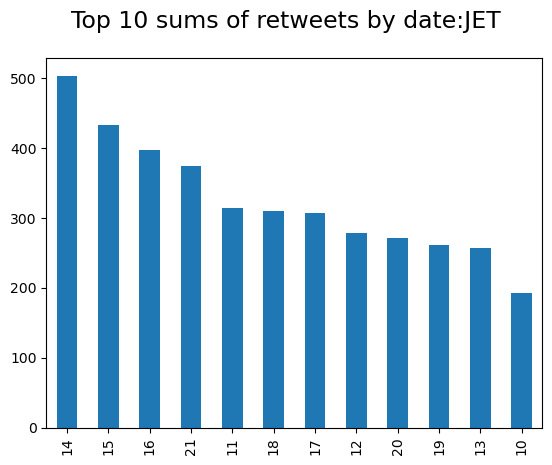

In [29]:
#hour_jet_re
hour_count=JET_re['hour'].value_counts()
hour_count
import matplotlib.pyplot as plt

plt.suptitle('Top 10 sums of retweets by date:JET', fontsize=17)
hour_count[:12].plot(kind='bar')

<AxesSubplot:>

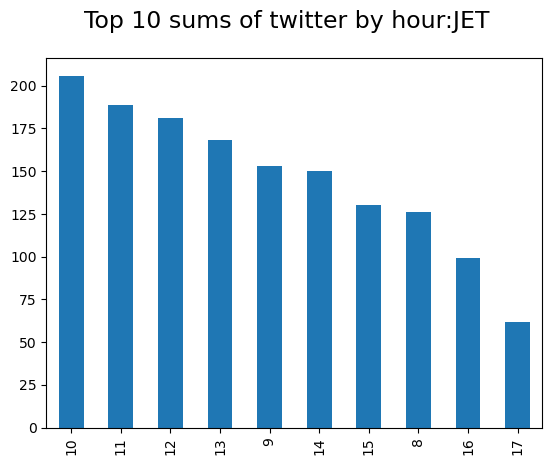

In [30]:
#hour_jet_or
hour_count=JET_or['hour'].value_counts()
hour_count
import matplotlib.pyplot as plt

plt.suptitle('Top 10 sums of twitter by hour:JET', fontsize=17)
hour_count[:10].plot(kind='bar')

In [31]:
import nltk.sentiment.vader as vd
from nltk import download
sia = vd.SentimentIntensityAnalyzer()
from nltk.tokenize import word_tokenize
df_posts['sentiment_score'] = df_posts['stemmed'].apply(lambda x: sum([ sia.polarity_scores(i)['compound'] for i in word_tokenize( ' '.join(x) )]) )

C:\Users\Jiang Bowen\AppData\Local\Temp\ipykernel_86012\3401872517.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_posts['sentiment_score'] = df_posts['stemmed'].apply(lambda x: sum([ sia.polarity_scores(i)['compound'] for i in word_tokenize( ' '.join(x) )]) )


In [32]:

df_posts['sent_clasification'] = pd.cut(df_posts['sentiment_score'],\
          [-5,-2, 0, 2 , 5],\
          right=True,\
          include_lowest=True,\
          labels=['snegative', 'negative', 'positive', 'spositive'])
JET = df_posts.loc[df_posts['user_id'].isin([272030125,21427907,25320756])]
Deliveroo = df_posts.loc[df_posts['user_id'].isin([884794020])]
Uber = df_posts.loc[df_posts['user_id'].isin([3100005042,1123948811691470849])]


#create dataframe only containts retweets 
JET_re = JET.loc[JET["replied_to_id"] != -1]
Deliveroo_re = Deliveroo.loc[Deliveroo["replied_to_id"] != -1]
Uber_re = Uber.loc[Uber["replied_to_id"] != -1]


#create dataframe only containts original posts
JET_or = JET.loc[JET["replied_to_id"] == -1]
Deliveroo_or = Deliveroo.loc[Deliveroo["replied_to_id"] == -1]
Uber_or = Uber.loc[Uber["replied_to_id"] == -1]



C:\Users\Jiang Bowen\AppData\Local\Temp\ipykernel_86012\966518766.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_posts['sent_clasification'] = pd.cut(df_posts['sentiment_score'],\


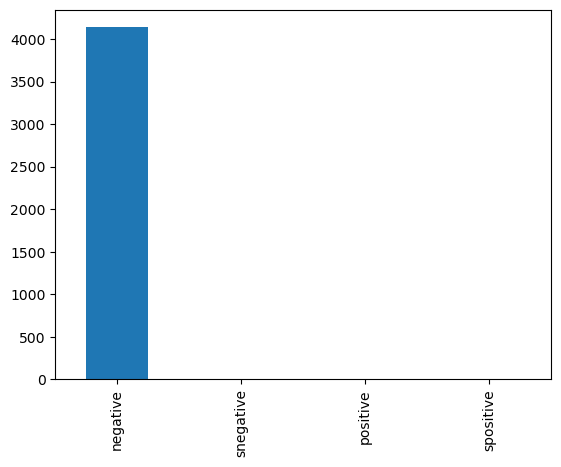

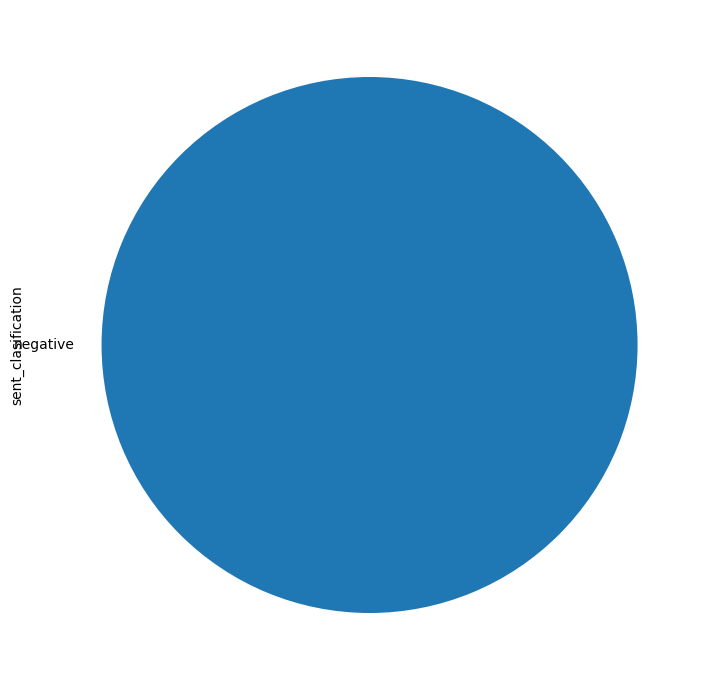

In [33]:
JET_re['sent_clasification'].value_counts().plot(kind='bar')
plt.figure(figsize=(15,7))
JET_re['sent_clasification'].value_counts().plot(kind='pie')
plt.grid(True)
plt.tight_layout()

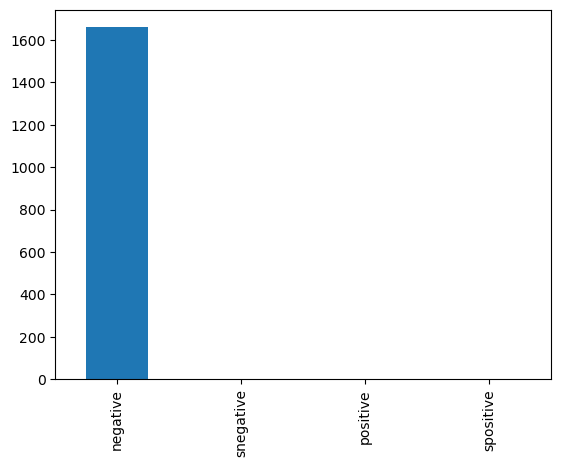

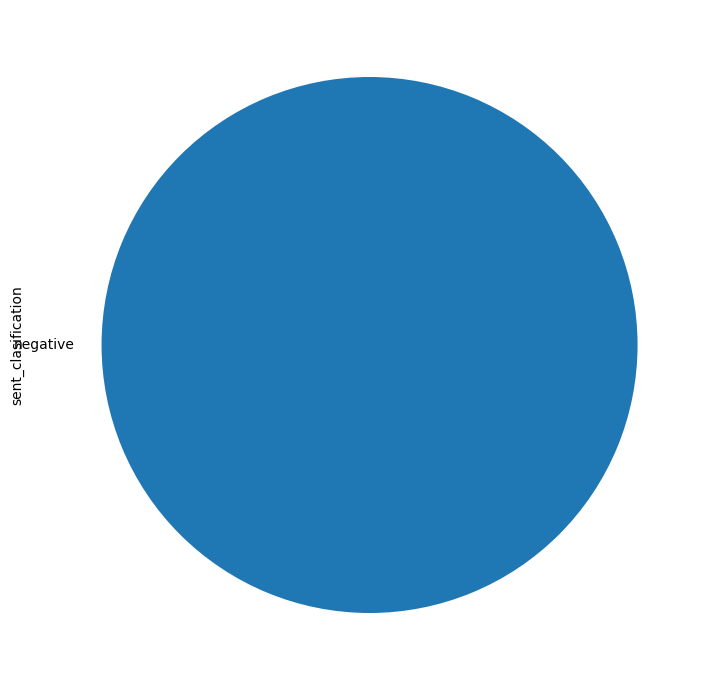

In [34]:
JET_or['sent_clasification'].value_counts().plot(kind='bar')
plt.figure(figsize=(15,7))
JET_or['sent_clasification'].value_counts().plot(kind='pie')
plt.grid(True)
plt.tight_layout()

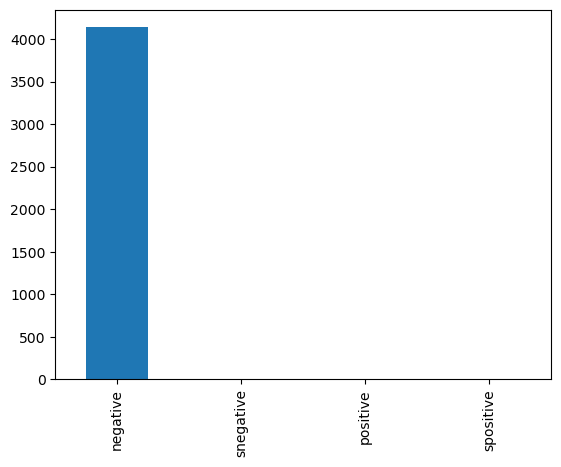

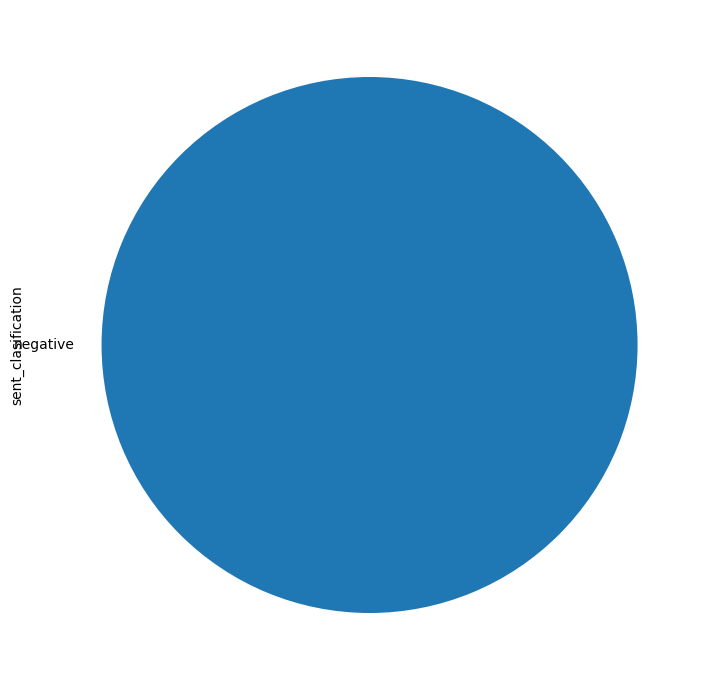

In [35]:
JET_re['sent_clasification'].value_counts().plot(kind='bar')
plt.figure(figsize=(15,7))
JET_re['sent_clasification'].value_counts().plot(kind='pie')
plt.grid(True)
plt.tight_layout()

In [36]:
JET_re['sent_clasification'].value_counts()

negative     4138
snegative       0
positive        0
spositive       0
Name: sent_clasification, dtype: int64

In [37]:
JET_or['sent_clasification'].value_counts()

negative     1660
snegative       0
positive        0
spositive       0
Name: sent_clasification, dtype: int64

In [59]:
import pandas as pd

output_file = "user_stats.xlsx"

with pd.ExcelWriter(output_file) as writer:
    for is_csr_value in [1, 0]:
        user_data = df_posts[df_posts['is_CSR'] == is_csr_value][['log_engage', 'similarity', 'sentiment_score', 'is_re', 'word_count', 'busy_time', 'is_pandemic']]
        descriptive_stats = user_data.describe()
        descriptive_stats.to_excel(writer, sheet_name=f"is_CSR_{is_csr_value}")

    all_data = df_posts[['log_engage', 'similarity', 'sentiment_score', 'is_re', 'word_count', 'busy_time', 'is_pandemic']]
    all_descriptive_stats = all_data.describe()
    all_descriptive_stats.to_excel(writer, sheet_name="All_Data")

print("Descriptive statistics saved to user_stats.xlsx")


Descriptive statistics saved to user_stats.xlsx


In [60]:
import pandas as pd

output_file = "user_stats_JET.xlsx"

with pd.ExcelWriter(output_file) as writer:
    for is_csr_value in [1, 0]:
        user_data = df_posts[df_posts['is_JET'] == is_csr_value][['log_engage', 'similarity', 'sentiment_score', 'is_re', 'word_count', 'busy_time', 'is_pandemic']]
        descriptive_stats = user_data.describe()
        descriptive_stats.to_excel(writer, sheet_name=f"is_JET{is_csr_value}")

    all_data = df_posts[['log_engage', 'similarity', 'sentiment_score', 'is_re', 'word_count', 'busy_time', 'is_pandemic']]
    all_descriptive_stats = all_data.describe()
    all_descriptive_stats.to_excel(writer, sheet_name="All_Data")

print("Descriptive statistics saved to user_stats.xlsx")


Descriptive statistics saved to user_stats.xlsx


### Regression

In [57]:
df_posts.loc[:, 'word_count'] = df_posts['stemmed'].apply(len)

C:\Users\Jiang Bowen\AppData\Local\Temp\ipykernel_86012\4053291298.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_posts.loc[:, 'word_count'] = df_posts['stemmed'].apply(len)


In [42]:
#user engagement
df_posts['engagement']=df_posts['retweet_count']+df_posts['like_count']+df_posts['reply_count']+df_posts['quote_count']
df_posts['log_engage']=np.log(df_posts['engagement']+1)

C:\Users\Jiang Bowen\AppData\Local\Temp\ipykernel_86012\3330781004.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_posts['engagement']=df_posts['retweet_count']+df_posts['like_count']+df_posts['reply_count']+df_posts['quote_count']
C:\Users\Jiang Bowen\AppData\Local\Temp\ipykernel_86012\3330781004.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_posts['log_engage']=np.log(df_posts['engagement']+1)


In [43]:
#CSR-RELATED
# define sustainability related content
df_posts['is_CSR'] = np.where(df_posts['text'].str.contains('colla|sustain|waste|plastic|recycle|pollutionResponsibility|Sustainable|Ethics|Accountability|Transparency|Environmental|Social|Charity|Donation|Community|Philanthropy|Giving|Volunteer|Empowerment|Equality|Diversity|Inclusion|Fairness|Ethical|Impactful|Green|Conservation|Sustainability|Humanitarian|Support|Corporate|Engagement|Initiative|Wellness|Stakeholder|Responsible|Welfare|Education|Contribution|Empathy|Empower|Non-profit|Resilience|Advocacy|Transparency|Respect|Partnerships|Progress|Collaboration|Empowering|Trust'), 1, 0)

C:\Users\Jiang Bowen\AppData\Local\Temp\ipykernel_86012\2693405030.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_posts['is_CSR'] = np.where(df_posts['text'].str.contains('colla|sustain|waste|plastic|recycle|pollutionResponsibility|Sustainable|Ethics|Accountability|Transparency|Environmental|Social|Charity|Donation|Community|Philanthropy|Giving|Volunteer|Empowerment|Equality|Diversity|Inclusion|Fairness|Ethical|Impactful|Green|Conservation|Sustainability|Humanitarian|Support|Corporate|Engagement|Initiative|Wellness|Stakeholder|Responsible|Welfare|Education|Contribution|Empathy|Empower|Non-profit|Resilience|Advocacy|Transparency|Respect|Partnerships|Progress|Collaboration|Empowering|Trust'), 1, 0)


In [44]:
#re
df_posts.loc[df_posts['replied_to_id'] == -1, 'is_re'] = 1
df_posts.loc[df_posts['replied_to_id'] != -1, 'is_re'] = 0


C:\Users\Jiang Bowen\AppData\Local\Temp\ipykernel_86012\3959262304.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_posts.loc[df_posts['replied_to_id'] == -1, 'is_re'] = 1


In [45]:
#create year,month,hour for charts  
df_posts['year'] = pd.to_datetime(df_posts['created_at']).dt.year
df_posts['month'] = pd.to_datetime(df_posts['created_at']).dt.month
df_posts['hour'] = pd.to_datetime(df_posts['created_at']).dt.hour
df_posts['busy_time'] = np.where(df_posts['hour'].isin([14, 16, 15, 17, 18, 19]), 1, 0)


C:\Users\Jiang Bowen\AppData\Local\Temp\ipykernel_86012\4283242395.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_posts['year'] = pd.to_datetime(df_posts['created_at']).dt.year
C:\Users\Jiang Bowen\AppData\Local\Temp\ipykernel_86012\4283242395.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_posts['month'] = pd.to_datetime(df_posts['created_at']).dt.month
C:\Users\Jiang Bowen\AppData\Local\Temp\ipykernel_86012\4283242395.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a

In [51]:
df_posts.rename(columns={'similirity': 'similarity', 'innovation': 'is_CSR', 'innovation': 'is_CSR'}, inplace=True)
df_posts['year'] = pd.to_datetime(df_posts['year'], format='%Y')
df_posts['month'] = pd.to_datetime(df_posts['month'], format='%m')
df_posts['is_pandemic'] = 0
df_posts.loc[(df_posts['year'] >= pd.to_datetime('2021')) & (df_posts['month'] >= pd.to_datetime('2021-01')), 'is_pandemic'] = 1

C:\Users\Jiang Bowen\AppData\Local\Temp\ipykernel_86012\4132505244.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_posts.rename(columns={'similirity': 'similarity', 'innovation': 'is_CSR', 'innovation': 'is_CSR'}, inplace=True)
C:\Users\Jiang Bowen\AppData\Local\Temp\ipykernel_86012\4132505244.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_posts['year'] = pd.to_datetime(df_posts['year'], format='%Y')
C:\Users\Jiang Bowen\AppData\Local\Temp\ipykernel_86012\4132505244.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

In [58]:
#5.1 main regression
results = smf.ols('log_engage ~ similarity + sentiment_score + is_re + word_count + busy_time+ is_pandemic', data=df_posts).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:             log_engage   R-squared:                       0.435
Model:                            OLS   Adj. R-squared:                  0.435
Method:                 Least Squares   F-statistic:                     2689.
Date:                Thu, 15 Jun 2023   Prob (F-statistic):               0.00
Time:                        15:10:13   Log-Likelihood:                -18338.
No. Observations:               13974   AIC:                         3.669e+04
Df Residuals:                   13969   BIC:                         3.672e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.6261      0.019     

D:\Anaconda\lib\site-packages\statsmodels\regression\linear_model.py:1918: RuntimeWarning: divide by zero encountered in scalar divide
  return np.sqrt(eigvals[0]/eigvals[-1])


In [53]:
#5.2 group comparison

treatment_group = df_posts[df_posts['is_CSR'] == 1]
control_group = df_posts[df_posts['is_CSR'] == 0]

# Regression analysis for the treatment group
treatment_results = smf.ols('log_engage ~ similarity + sentiment_score + is_re + word_count + busy_time + is_pandemic', data=treatment_group).fit()

# Regression analysis for the control group
control_results = smf.ols('log_engage ~ similarity + sentiment_score + is_re + word_count + busy_time + is_pandemic', data=control_group).fit()

# Summarize the regression results
results_summary = summary_col([treatment_results, control_results], stars=True)

# Print the results to the console
print(results_summary)



                log_engage I log_engage II
------------------------------------------
Intercept       0.3641**     0.6445***    
                (0.1496)     (0.0191)     
similarity      -0.0027      0.0151**     
                (0.0604)     (0.0072)     
sentiment_score 0.0000***    0.0000***    
                (0.0000)     (0.0000)     
is_re           1.7914***    2.1118***    
                (0.1247)     (0.0213)     
word_count      0.0025***    -0.0030***   
                (0.0008)     (0.0001)     
busy_time       -0.0069      0.1781***    
                (0.0970)     (0.0155)     
is_pandemic     0.0000       0.0000       
                (0.0000)     (0.0000)     
R-squared       0.5403       0.4208       
R-squared Adj.  0.5337       0.4206       
Standard errors in parentheses.
* p<.1, ** p<.05, ***p<.01


In [54]:
#5.3 ATE
import statsmodels.api as sm
from statsmodels.iolib.summary2 import summary_col
import scipy.stats as stats

# Perform regression analysis for the treatment group
treatment_results = smf.ols('log_engage ~ similarity + sentiment_score + is_re + word_count + busy_time + is_pandemic', data=treatment_group).fit()

# Perform regression analysis for the control group
control_results = smf.ols('log_engage ~ similarity + sentiment_score + is_re + word_count + busy_time + is_pandemic', data=control_group).fit()

# Summarize the regression results
results_summary = summary_col([treatment_results, control_results], stars=True)

# Print the results to the console
print(results_summary)

# Extract coefficients and standard errors for the treatment group
treatment_coefs = treatment_results.params
treatment_std_errors = treatment_results.bse

# Extract coefficients and standard errors for the control group
control_coefs = control_results.params
control_std_errors = control_results.bse

# Calculate the difference in coefficients between treatment and control groups
coef_diff = treatment_coefs - control_coefs

# Perform a statistical test to determine the significance of the differences
t_values = coef_diff / np.sqrt(treatment_std_errors**2 + control_std_errors**2)
p_values = 2 * (1 - stats.t.cdf(np.abs(t_values), df=len(treatment_group) + len(control_group) - len(coef_diff)))

# Create a DataFrame to display the results
ate_results = pd.DataFrame({'Coefficient Difference': coef_diff, 'Standard Error (Treatment)': treatment_std_errors, 'Standard Error (Control)': control_std_errors, 'T-value': t_values, 'P-value': p_values})

# Print the ATE results
print(ate_results)



                log_engage I log_engage II
------------------------------------------
Intercept       0.3641**     0.6445***    
                (0.1496)     (0.0191)     
similarity      -0.0027      0.0151**     
                (0.0604)     (0.0072)     
sentiment_score 0.0000***    0.0000***    
                (0.0000)     (0.0000)     
is_re           1.7914***    2.1118***    
                (0.1247)     (0.0213)     
word_count      0.0025***    -0.0030***   
                (0.0008)     (0.0001)     
busy_time       -0.0069      0.1781***    
                (0.0970)     (0.0155)     
is_pandemic     0.0000       0.0000       
                (0.0000)     (0.0000)     
R-squared       0.5403       0.4208       
R-squared Adj.  0.5337       0.4206       
Standard errors in parentheses.
* p<.1, ** p<.05, ***p<.01
                 Coefficient Difference  Standard Error (Treatment)  \
Intercept                 -2.803490e-01                1.495588e-01   
similarity              

In [55]:
#5.3 PSM
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import NearestNeighbors

# Create a new column 'treatment' and set treatment group to 1 and control group to 0 based on 'is_CSR'
df_posts['treatment'] = np.where(df_posts['is_CSR'] == 1, 1, 0)

# Extract variables for matching
matching_variables = ['sentiment_score', 'is_re', 'word_count', 'busy_time', 'is_pandemic']

# Perform propensity score matching
matcher = NearestNeighbors(n_neighbors=1)
matcher.fit(df_posts[matching_variables])
distances, indices = matcher.kneighbors(df_posts[matching_variables])

# Extract indices of matched samples
matched_indices = indices[:, 0]

# Extract data for matched treatment and control groups
matched_treatment_group = df_posts.loc[df_posts.index.isin(matched_indices) & (df_posts['treatment'] == 1)]
matched_control_group = df_posts.loc[df_posts.index.isin(matched_indices) & (df_posts['treatment'] == 0)]

# Perform regression analysis for treatment group
treatment_results = smf.ols('log_engage ~ similarity + sentiment_score + is_re + word_count + busy_time + is_pandemic', data=matched_treatment_group).fit()

# Perform regression analysis for control group
control_results = smf.ols('log_engage ~ similarity + sentiment_score + is_re + word_count + busy_time + is_pandemic', data=matched_control_group).fit()

# Summarize regression results
results_summary = summary_col([treatment_results, control_results], stars=True)

# Print results to console
print(results_summary)

# Extract coefficients and standard errors for treatment and control groups
treatment_coefs = treatment_results.params
treatment_std_errors = treatment_results.bse

control_coefs = control_results.params
control_std_errors = control_results.bse

# Calculate the difference in coefficients between treatment and control groups
coef_diff = treatment_coefs - control_coefs

# Perform statistical test to determine the significance of the differences
t_values = coef_diff / np.sqrt(treatment_std_errors**2 + control_std_errors**2)
p_values = 2 * (1 - stats.t.cdf(np.abs(t_values), df=len(matched_treatment_group) + len(matched_control_group) - len(coef_diff)))

# Create DataFrame to display results
ate_results = pd.DataFrame({'Coefficient Difference': coef_diff, 'Standard Error (Treatment)': treatment_std_errors, 'Standard Error (Control)': control_std_errors, 'T-value': t_values, 'P-value': p_values})

# Print ATE results
print(ate_results)



                log_engage I log_engage II
------------------------------------------
Intercept       0.0248       0.8327***    
                (0.4705)     (0.0953)     
similarity      0.2545       -0.0205      
                (0.2360)     (0.0434)     
sentiment_score 0.0000***    -0.0000***   
                (0.0000)     (0.0000)     
is_re           1.5943***    2.5924***    
                (0.3475)     (0.0955)     
word_count      0.0037*      -0.0036***   
                (0.0020)     (0.0006)     
busy_time       0.6108*      0.3079***    
                (0.3090)     (0.0717)     
is_pandemic     0.0000       0.0000       
                (0.0000)     (0.0000)     
R-squared       0.7032       0.4637       
R-squared Adj.  0.6407       0.4614       
Standard errors in parentheses.
* p<.1, ** p<.05, ***p<.01
                 Coefficient Difference  Standard Error (Treatment)  \
Intercept                 -8.079404e-01                4.704625e-01   
similarity              

C:\Users\Jiang Bowen\AppData\Local\Temp\ipykernel_86012\3902814403.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_posts['treatment'] = np.where(df_posts['is_CSR'] == 1, 1, 0)


In [56]:
#5.4 JET-group comparison
df_posts['is_JET'] = df_posts['user_id'].isin([272030125, 21427907, 25320756]).astype(int)
import statsmodels.api as sm
from statsmodels.iolib.summary2 import summary_col
import scipy.stats as stats
treatment_group = df_posts[df_posts['is_JET'] == 1]
control_group = df_posts[df_posts['is_JET'] == 0]

# Perform regression analysis for the treatment group
treatment_results = smf.ols('log_engage ~ similarity + sentiment_score + is_re + word_count + busy_time + is_pandemic', data=treatment_group).fit()

# Perform regression analysis for the control group
control_results = smf.ols('log_engage ~ similarity + sentiment_score + is_re + word_count + busy_time + is_pandemic', data=control_group).fit()

# Summarize the regression results
results_summary = summary_col([treatment_results, control_results], stars=True)

# Print the results to the console
print(results_summary)

# Extract coefficients and standard errors for the treatment group
treatment_coefs = treatment_results.params
treatment_std_errors = treatment_results.bse

# Extract coefficients and standard errors for the control group
control_coefs = control_results.params
control_std_errors = control_results.bse

# Calculate the difference in coefficients between the treatment and control groups
coef_diff = treatment_coefs - control_coefs

# Perform a statistical test to determine the significance of the differences
t_values = coef_diff / np.sqrt(treatment_std_errors**2 + control_std_errors**2)
p_values = 2 * (1 - stats.t.cdf(np.abs(t_values), df=len(treatment_group) + len(control_group) - len(coef_diff)))

# Create a DataFrame to display the results
ate_results = pd.DataFrame({'Coefficient Difference': coef_diff, 'Standard Error (Treatment)': treatment_std_errors, 'Standard Error (Control)': control_std_errors, 'T-value': t_values, 'P-value': p_values})

# Print the ATE results
print(ate_results)



                log_engage I log_engage II
------------------------------------------
Intercept       -0.0123      0.8524***    
                (0.0258)     (0.0249)     
similarity      0.0312***    0.0088       
                (0.0099)     (0.0091)     
sentiment_score -0.0000***   0.0000***    
                (0.0000)     (0.0000)     
is_re           1.9601***    2.2339***    
                (0.0208)     (0.0349)     
word_count      0.0023***    -0.0050***   
                (0.0002)     (0.0002)     
busy_time       -0.0102      0.2577***    
                (0.0185)     (0.0209)     
is_pandemic     0.0000       0.0000       
                (0.0000)     (0.0000)     
R-squared       0.7027       0.3475       
R-squared Adj.  0.7025       0.3472       
Standard errors in parentheses.
* p<.1, ** p<.05, ***p<.01
                 Coefficient Difference  Standard Error (Treatment)  \
Intercept                 -8.647756e-01                2.580919e-02   
similarity              

C:\Users\Jiang Bowen\AppData\Local\Temp\ipykernel_86012\617407674.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_posts['is_JET'] = df_posts['user_id'].isin([272030125, 21427907, 25320756]).astype(int)
